# Feature Engineering of Restaurant Region Information

- Region (Feature Engineering)
- Walking Distance from Station Exits
- Restaurant Within Malls

## 1. Data Preparation

In [1]:
# General Data Cleaning/Stats
import pandas as pd
import numpy as np
import re

# Geosptial Analysis
import geopandas as gpd #conda install geopandas
# conda install -c conda-forge nbformat
import plotly.express as px #conda install -c plotly plotly_express
from plotly.express import choropleth_mapbox
from shapely.geometry import shape, Point
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# General Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# python script containing mapbox token (not uploaded on GitHub)
from tokens import mapbox_token

import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_palette("rocket")
pal = sns.color_palette("rocket")
hex_colors = pal.as_hex()
print(hex_colors)
pal

['#35193e', '#701f57', '#ad1759', '#e13342', '#f37651', '#f6b48f']


[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

### Loading of Datasets

In [3]:
df_restaurant = pd.read_csv("data/full_restaurant_rating_data.csv")
df_is_in_mall = pd.read_csv("data/restaurant_is_in_mall.csv")
df_walking_duration_from_station_exit = pd.read_csv("data/restaurant_walking_duration_from_station_exit.csv")
df_restaurant_nearest_exit = pd.read_csv('data/restaurant_nearest_station_exit.csv')

In [4]:
subset_columns = [
    'name',
    'address',
    'region',
    'latitude',
    'longitude',
    'overall_rating',
    'num_of_reviews',
    'url'
]

df_restaurant_subset = df_restaurant[subset_columns].copy()
df_restaurant_subset = df_restaurant_subset.merge(df_is_in_mall[['url', 'is_in_mall', 'mall']], on='url', how='left')
df_restaurant_subset = df_restaurant_subset.merge(df_walking_duration_from_station_exit, on='url', how='left')
df_restaurant_subset = df_restaurant_subset.merge(df_restaurant_nearest_exit[['station_name', 'station_line_color', 'url', 'distance']], on='url', how='left')

### Drop Missing Ratings and Number of Reviews < 3

In [5]:
############# Drop Ratings = -1
df_restaurant_subset = df_restaurant_subset[df_restaurant_subset['overall_rating'] != -1].copy()

print('Percentage of Restaurants:')
df_restaurant_subset['overall_rating'].value_counts().sort_index() / len(df_restaurant_subset) * 100 

Percentage of Restaurants:


1.0     0.775675
1.5     0.330955
2.0     1.385872
2.5     2.347709
3.0    10.662943
3.5    19.857276
4.0    37.832247
4.5    17.581963
5.0     9.225359
Name: overall_rating, dtype: float64

In [6]:
############# Drop Num_of_reviews < 3
df_num_of_reviews_capped = df_restaurant_subset[df_restaurant_subset['num_of_reviews'] >= 3].copy()

########### Potentially: 4.5 / 5.0: Outstanding, 4.0: Average, 3.5 and below: Below Average
print(f"Total Observations: {len(df_num_of_reviews_capped)}")
print(f"Below Average: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['overall_rating'] < 4.0]) * 100 / len(df_num_of_reviews_capped)}%")
print(f"Average: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['overall_rating'] == 4.0]) * 100 / len(df_num_of_reviews_capped)}%")
print(f"Outstanding: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['overall_rating'] >= 4.5]) * 100 / len(df_num_of_reviews_capped)}%")

Total Observations: 7226
Below Average: 37.62800996401882%
Average: 37.946305009687244%
Outstanding: 24.425685026293937%


### Dropping Rows with missing Walking Distance

In [7]:
print(f"Total Rows: {len(df_num_of_reviews_capped)}")
print(f"Good Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'] > 100])}")
print(f"Bad Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'] < 100])}")
print(f"Missing Geolocations: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['longitude'].isna()])}")
print(f"Missing Walking Distance: {len(df_num_of_reviews_capped[df_num_of_reviews_capped['walking_distance'].isna()])}")

Total Rows: 7226
Good Geolocations: 7194
Bad Geolocations: 0
Missing Geolocations: 32
Missing Walking Distance: 34


In [8]:
df_num_of_reviews_capped = df_num_of_reviews_capped.dropna(subset=['walking_distance'])

## 2. Exploring Region feature scraped from TripAdvisor

- Region obtained from TripAdvisor is identified as a Problematic Feature
- The regions labeled are inconsistent (relative to the restaurant's true geographical location). For example a restaurant located in Marina Bay Sands could be assigned a region 'Marina Centre', and another could be assigned 'Central Area/City Area' 

[TODO]: FIND SPECIFIC E.G.

In [9]:
print(f"Total Number of TripAdvisor Regions: {len(df_num_of_reviews_capped['region'].value_counts())}")
print("Percentage of Restaurants in these regions:")
print(df_num_of_reviews_capped['region'].value_counts().head(10) / len(df_num_of_reviews_capped) * 100)

Total Number of TripAdvisor Regions: 133
Percentage of Restaurants in these regions:
Central Area/City Area    19.035039
Outram                     9.607898
Bukit Merah                4.213014
Boulevard                  4.199110
Somerset                   3.072859
Marine Parade              3.031146
Bedok                      2.683537
Changi                     2.544494
Marina Centre              2.502781
City Hall                  2.169077
Name: region, dtype: float64


## 3. Using Geospatial Information to engineer a "new" Region feature

### Convert dataframe into a GeoDataFrame

In [10]:
gdf_restaurant = gpd.GeoDataFrame(df_num_of_reviews_capped, geometry= gpd.points_from_xy(df_num_of_reviews_capped['longitude'], df_num_of_reviews_capped['latitude']), crs='epsg:4326')

### Loading a Subzones Shapefile Data
- Containing Geographical Boundary in Singapore (defined by Urban Redevelopment Authority URA)
- 3 Levels of Boundary: Area (e.g. East, West), Town (e.g. Bishan), District (e.g. Marymount)

In [11]:
gdf_subzones = gpd.read_file('data/singapore_subzones_2019.geojson', crs='epsg:4326')
gdf_subzones['extracted_description'] = gdf_subzones['Description'].apply(
    lambda x: re.findall("(?<=<td>)[\w*\s*\-*]*\w+(?=</td>)", x)
)

def extract_district(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[1]
        else:
            np.nan
    else:
        return np.nan

def extract_town(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[4]
        else:
            return x[3]
    else:
        return np.nan

def extract_region(x):
    if len(x) > 0:
        if len(x[3]) == 1:
            return x[6]
        else:
            return x[5]
    else:
        return np.nan

gdf_subzones['district'] = gdf_subzones['extracted_description'].apply(lambda x: extract_district(x))
gdf_subzones['town'] = gdf_subzones['extracted_description'].apply(lambda x: extract_town(x))
gdf_subzones['area'] = gdf_subzones['extracted_description'].apply(lambda x: extract_region(x))        

gdf_subzones.drop(columns=['Name', 'Description', 'extracted_description'], inplace=True)

### Geospatial Join of Region Dataset to map District/Town/Area that each restaurant is located in

In [12]:
gdf_restaurant = gpd.sjoin(
    gdf_restaurant,
    gdf_subzones,
    how='left',
)

gdf_restaurant.drop(columns=['index_right'], inplace=True)

### Handling Missing District/Town/Area
- It is identified from Geospatial Visualisation that the restaurants that are not mapped to any geographical boundaries are located offshore. Hence the district/town/area of these restaurants are imputed based on the nearest boundary from the restaurant

In [13]:
gdf_restaurant_missing_location = gdf_restaurant[gdf_restaurant['area'].isna()].copy()
gdf_restaurant_missing_location

,name,address,region,latitude,longitude,overall_rating,num_of_reviews,url,is_in_mall,mall,walking_distance,walking_duration,station_name,station_line_color,distance,geometry,district,town,area
2537,Goldenbeach Seafood Paradise,907 East Coast Road #01-01 Springvale Springva...,NaN,1.391251,103.97471,4.0,27,https://www.tripadvisor.com.sg/Restaurant_Revi...,0.0,NaN,6161.8,4436.4,PASIR RIS MRT STATION,GREEN,3481.244390,POINT (103.97471 1.39125),NaN,NaN,NaN
2754,Rasa Istimewa,"6A Admiralty Road West Waterfront Park, Singap...",NaN,1.453914,103.77774,3.5,37,https://www.tripadvisor.com.sg/Restaurant_Revi...,0.0,NaN,2895.9,2085.0,WOODLANDS MRT STATION,RED,2116.644183,POINT (103.77774 1.45391),NaN,NaN,NaN
2815,Patro's Sports Bar & Restaurant,920 East Coast Parkway Parkland Green #01-18/1...,NaN,1.298121,103.90860,3.5,52,https://www.tripadvisor.com.sg/Restaurant_Revi...,0.0,NaN,3001.7,2161.2,EUNOS MRT STATION,GREEN,2441.963490,POINT (103.90860 1.29812),NaN,NaN,NaN
5070,Stewords Riverboat,31 Marina Coastal Drive Marina South Pier Bert...,NaN,1.270886,103.86388,3.5,7,https://www.tripadvisor.com.sg/Restaurant_Revi...,0.0,NaN,52.4,37.8,MARINA SOUTH PIER MRT STATION,RED,69.574040,POINT (103.86388 1.27089),NaN,NaN,NaN


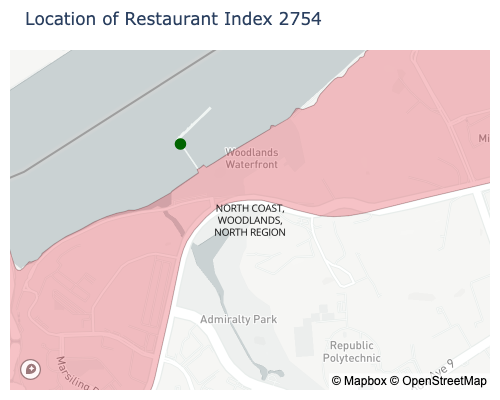

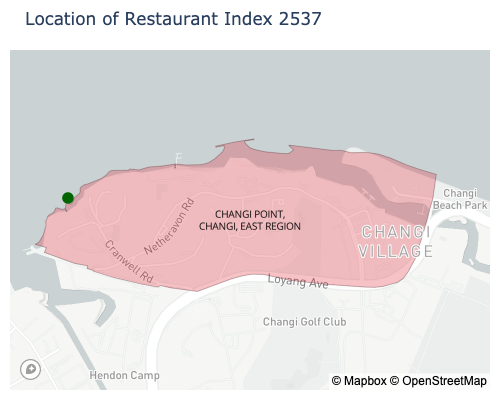

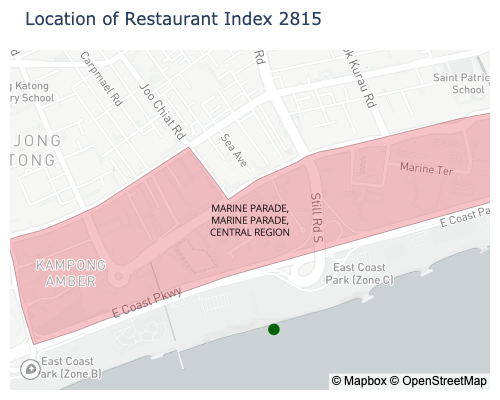

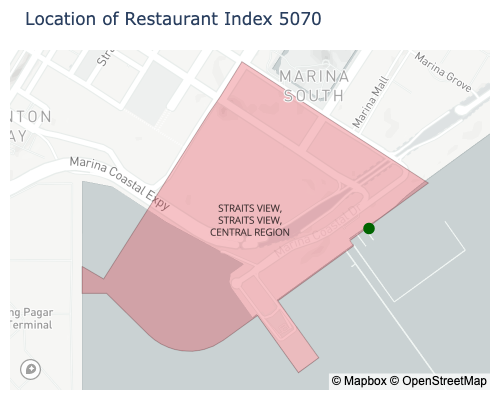

In [15]:
for res_id, region_id in [(2754, 323), (2537, 258), (2815, 93), (5070, 12)]:
    gdf_subset_subzones = gdf_subzones[gdf_subzones.index == region_id]
    fig = px.choropleth_mapbox(
        gdf_subset_subzones,
        geojson=gdf_subset_subzones.geometry,
        locations=gdf_subset_subzones.index,
        opacity=0.3,
        color=gdf_subset_subzones.district,
        color_discrete_map={gdf_subset_subzones.loc[:,'district'].iloc[0]: hex_colors[3]},
        zoom=13, # 11.2 for CBD  
        labels={'district': 'District', 'town': 'Town', 'area': 'Area'},
    )

    fig.update_traces(showlegend=False)

    fig2 = go.Figure(go.Scattermapbox(
        mode="markers",
        lat=gdf_restaurant_missing_location['latitude'],
        lon=gdf_restaurant_missing_location['longitude'],
        marker= {"size": 12, "color": "darkgreen"},
    ))

    fig3 = go.Figure(go.Scattermapbox(        
        mode="text",
        lat=gdf_subset_subzones.centroid.y,
        lon=gdf_subset_subzones.centroid.x,
        text=f"{gdf_subset_subzones.iloc[0]['district']}, {gdf_subset_subzones.iloc[0]['town']}, {gdf_subset_subzones.iloc[0]['area']}",
    ))

    fig3.update_layout(
        width=500,
        height=400,
        mapbox=dict(center=go.layout.mapbox.Center(
                lat= gdf_subset_subzones.iloc[0,:].geometry.centroid.y,
                lon= gdf_subset_subzones.iloc[0,:].geometry.centroid.x,        
            ), zoom=14),        
        title=f"Location of Restaurant Index {res_id}",
        margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
        mapbox_accesstoken=mapbox_token,
        # mapbox= {'style': 'outdoors'},
        showlegend=False,        
    )

    fig3.update_traces(
        showlegend=False,
        mode="text", 
        text= 
        f"{gdf_subset_subzones.iloc[0]['district']}, {gdf_subset_subzones.iloc[0]['town']}, {gdf_subset_subzones.iloc[0]['area']}",
        textfont=dict(size=10, color='black')
    )

    fig3.add_trace(fig2.data[0])
    fig3.add_trace(fig.data[0])

    fig3.show("png")

In [16]:
gdf_restaurant.loc[2537, 'district'] = 'CHANGI POINT'
gdf_restaurant.loc[2537, 'town'] = 'CHANGI'
gdf_restaurant.loc[2537, 'area'] = 'EAST REGION'

gdf_restaurant.loc[2754, 'district'] = 'NORTH COAST'
gdf_restaurant.loc[2754, 'town'] = 'WOODLANDS'
gdf_restaurant.loc[2754, 'area'] = 'NORTH REGION'

gdf_restaurant.loc[2815, 'district'] = 'MARINE PARADE'
gdf_restaurant.loc[2815, 'town'] = 'MARINE PARADE'
gdf_restaurant.loc[2815, 'area'] = 'CENTRAL REGION'

gdf_restaurant.loc[5070, 'district'] = 'STRAITS VIEW'
gdf_restaurant.loc[5070, 'town'] = 'STRAITS VIEW'
gdf_restaurant.loc[5070, 'area'] = 'CENTRAL REGION'

### Visualising Number of Restaurants in each Area
- With the 3 layers of boundaries, we will inspect layer by layer to identify the boundary best suited for our project, beginning with the largest boundary, Area (North Region, North-East Region, East Region, Central Region, West Region)
- We will visualise the number of restaurants in our dataset within each boundary. We aim to ensure that the new "region" we engineered is fairly distributed and not skewed towards any particular label

In [17]:
# aggregating District boundaries to form Area boundary

df_region_area_rating = gdf_restaurant.groupby(['area']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_area_rating.columns = df_region_area_rating.columns.droplevel(1)
df_region_area_rating.reset_index(drop=False, inplace=True)
df_region_area_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_area = gdf_subzones.dissolve(by='area').reset_index(drop=False)[['district', 'town', 'area', 'geometry']]
df_region_area_rating = df_region_area_rating.merge(gdf_area, on='area', how='left')
gdf_region_area_rating = gpd.GeoDataFrame(df_region_area_rating, geometry='geometry', crs='epsg:4326')

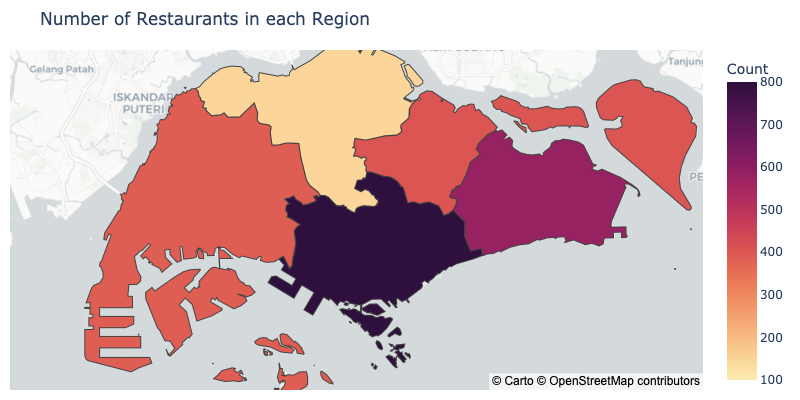

In [18]:
fig = px.choropleth_mapbox(
    gdf_region_area_rating,
    geojson = gdf_region_area_rating.geometry,
    locations = gdf_region_area_rating.index,
    labels={
        'num_of_restaurants': 'Count'
    },
    color='num_of_restaurants',
    color_continuous_scale='matter',
    range_color=(100,800),
    hover_data=['area'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each Region",
    margin={'r': 10, 'l': 10, 'b': 10, 't': 50},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

<strong>Observations:</strong>

- The Central Region has overwhelmingly more restaurants than the other regions. 
- The East Region has the second most number of restaurants and is significantly greater than that of the West and North-East Region
- The North Region has the least region among all areas

### Number of Restaurants within the Towns in the Central and East Regions
- Due to the unequal distribution as shown above, we will like to "break" the Central and East region into smaller boundaries so that the sub-boundaries have a number of restaurants that is closer to that of the North, North-East and West Regions.
- We will next look into the Town boundaries of the Central and East Regions.

In [19]:
# aggregating District boundaries to form Town boundary

df_region_town_rating = gdf_restaurant.groupby(['town']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_town_rating.columns = df_region_town_rating.columns.droplevel(1)
df_region_town_rating.reset_index(drop=False, inplace=True)
df_region_town_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_town = gdf_subzones.dissolve(by='town').reset_index(drop=False)[['town', 'area', 'geometry']]
gdf_region_town_rating = df_region_town_rating.merge(gdf_town, on='town', how='left')
gdf_region_town_rating = gpd.GeoDataFrame(gdf_region_town_rating, geometry='geometry', crs='epsg:4326')

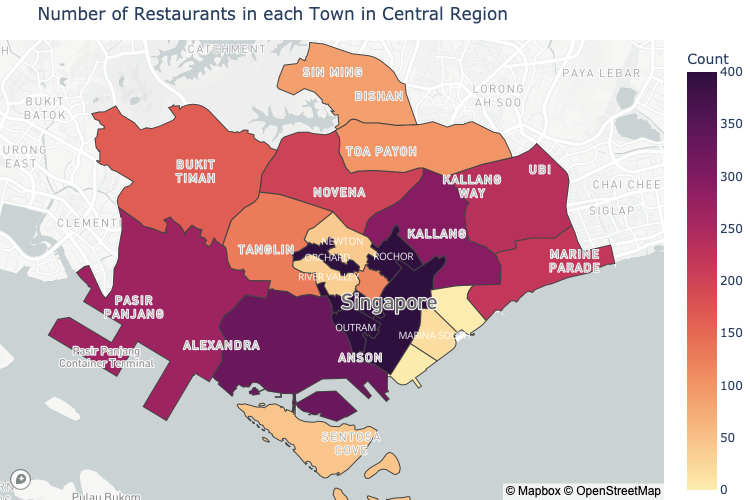

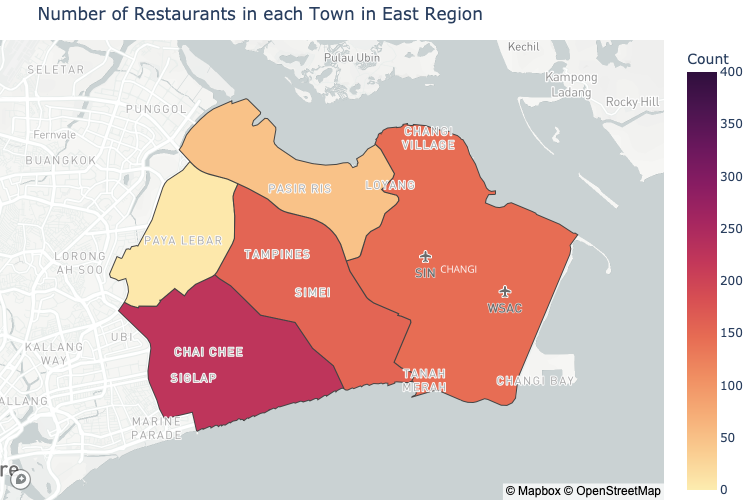

In [20]:
for i in [('CENTRAL REGION', 1.3, 103.835, 'Central'), ('EAST REGION', 1.35, 103.96, 'East')]:
    gdf_region_town_rating_subset = gdf_region_town_rating[gdf_region_town_rating['area'] == i[0]].copy()
    fig_text = go.Figure(go.Scattermapbox(        
        mode="text",
        lat=gdf_region_town_rating_subset.centroid.y,
        lon=gdf_region_town_rating_subset.centroid.x,
        text=gdf_region_town_rating_subset['town'],
        textfont=dict(size=10, color='white')
    ))

    fig = px.choropleth_mapbox(
        gdf_region_town_rating_subset,
        geojson = gdf_region_town_rating_subset.geometry,
        locations = gdf_region_town_rating_subset.index,
        color='num_of_restaurants',
        color_continuous_scale='matter',
        range_color=(0,400),
        hover_data=['town', 'area'],
        labels={'num_of_restaurants': 'Count'}
    )    

    fig.update_layout(
        width=750,
        height=500,
        mapbox=dict(center=go.layout.mapbox.Center(
                lat= i[1],
                lon= i[2],
            ), zoom=11.2),
        mapbox_accesstoken=mapbox_token,
        title=f"Number of Restaurants in each Town in {i[3]} Region",
        margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
        showlegend=False,        
    )

    fig.add_traces(fig_text.data[0])
    fig.show("png")

In [21]:
gdf_region_town_rating_central = gdf_region_town_rating[gdf_region_town_rating['area'] == 'CENTRAL REGION'].copy()
gdf_region_town_rating_central.sort_values(['num_of_restaurants'], ascending=False, inplace=True)
gdf_region_town_rating_central.reset_index(drop=True, inplace=True)

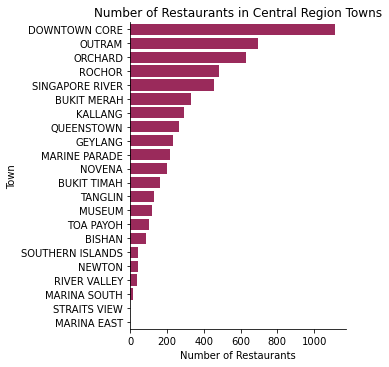

In [22]:
ax = sns.catplot(
    y = 'town',
    x = 'num_of_restaurants',
    data = gdf_region_town_rating_central,
    kind='bar',
    color=hex_colors[2]
)

ax.fig.gca().set_title("Number of Restaurants in Central Region Towns")
ax.fig.gca().set_ylabel("Town")
ax.fig.gca().set_xlabel("Number of Restaurants")
plt.show()

<strong>Observations:</strong>

- In the Central Region, Downtown Core has a much larger number of restaurants than the other towns. We will take a closer look at the districts within the Downtown Core next.
- For towns that have very few counts such as Straits View and Marina East, they will be "merged" into towns.
- In the East Region, Bedok has the largest number of restaurants. The differences in counts across the towns is smaller than that of Central Region. Paya lebar and Pasir Ris will be merged into the Tampines town as they have slightly fewer counts of restaurants.

### Further Breaking Down Downtown Core into Districts

In [23]:
df_region_district_rating = gdf_restaurant.groupby(['district']).agg({
    'url': ['count'],
    'overall_rating': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_region_district_rating.columns = df_region_district_rating.columns.droplevel(1)
df_region_district_rating.reset_index(drop=False, inplace=True)
df_region_district_rating.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
}, inplace=True)

gdf_district = gdf_subzones.dissolve(by='district').reset_index(drop=False)[['district', 'town', 'area', 'geometry']]
df_region_district_rating = df_region_district_rating.merge(gdf_district, on='district', how='left')
gdf_region_district_rating = gpd.GeoDataFrame(df_region_district_rating, geometry='geometry', crs='epsg:4326')

gdf_region_district_rating_downtown = gdf_region_district_rating[gdf_region_district_rating['town'] == 'DOWNTOWN CORE']

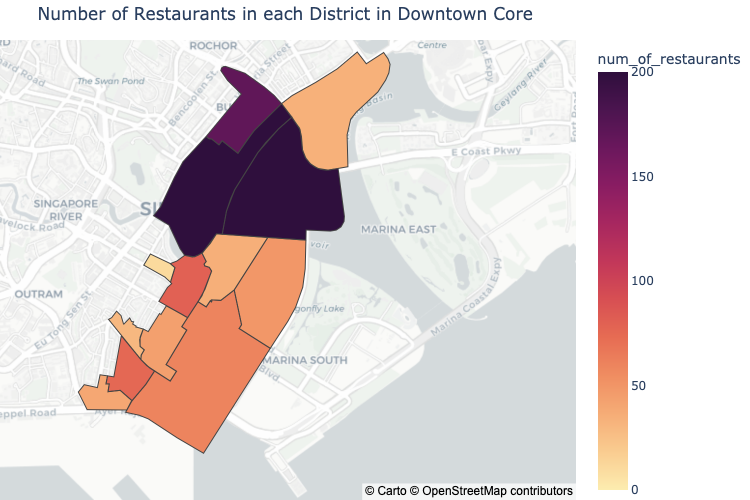

In [24]:
fig = px.choropleth_mapbox(
    gdf_region_district_rating_downtown,
    geojson = gdf_region_district_rating_downtown.geometry,
    locations = gdf_region_district_rating_downtown.index,
    color='num_of_restaurants',
    color_continuous_scale='matter',
    range_color=(0,200),
    hover_data=['town', 'area', 'district'],
    width=750,
    height=500,
    center= {
        'lat': 1.285,
        'lon': 103.86
    },
    zoom=12.95 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each District in Downtown Core",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")

# BUGIS + CITY HALL
# MARINA CENTRE + NICOLL
# REMAINING --> Downtown Core

<strong>Observations:</strong>

- The Districts in the northern regions have more restaurants than those of the southern region. The districts in the southern region will then be grouped together.

### Grouping District/Towns into "New" Region Lables

In [25]:
# ---------------------------------------------- #
gdf_town_paya_lebar_tampines_pasir_ris = gdf_town[gdf_town['town'].isin([
    'PAYA LEBAR', 'TAMPINES', 'PASIR RIS'])]

gdf_town_paya_lebar_tampines_pasir_ris = gdf_town_paya_lebar_tampines_pasir_ris.dissolve('area').reset_index(drop=False)
gdf_town_paya_lebar_tampines_pasir_ris.loc[0, 'town'] = 'PAYA LEBAR, TAMPINES, PASIR RIS'

# ---------------------------------------------- #
gdf_town_bishan_toa_payoh = gdf_town[gdf_town['town'].isin([
    'BISHAN', 'TOA PAYOH'])]

gdf_town_bishan_toa_payoh = gdf_town_bishan_toa_payoh.dissolve('area').reset_index(drop=False)
gdf_town_bishan_toa_payoh.loc[0, 'town'] = 'BISHAN, TOA PAYOH'

# ---------------------------------------------- #
gdf_town_rochor = gdf_town[gdf_town['town'].isin([
    'MUSEUM', 'ROCHOR'])]

gdf_town_rochor = gdf_town_rochor.dissolve('area').reset_index(drop=False)
gdf_town_rochor.loc[0, 'town'] = 'ROCHOR'

# ---------------------------------------------- #
gdf_town_singapore_river = gdf_town[gdf_town['town'].isin([
    'RIVER VALLEY', 'SINGAPORE RIVER'])]

gdf_town_singapore_river = gdf_town_singapore_river.dissolve('area').reset_index(drop=False)
gdf_town_singapore_river.loc[0, 'town'] = 'SINGAPORE RIVER'

# ---------------------------------------------- #
gdf_town_newtown_orchard = gdf_town[gdf_town['town'].isin([
    'NEWTON', 'ORCHARD'])]

gdf_town_newtown_orchard = gdf_town_newtown_orchard.dissolve('area').reset_index(drop=False)
gdf_town_newtown_orchard.loc[0, 'town'] = 'NEWTON, ORCHARD'

# ---------------------------------------------- #
gdf_town_bukit_merah_southern_islands = gdf_town[gdf_town['town'].isin([
    'BUKIT MERAH', 'SOUTHERN ISLANDS'])]

gdf_town_bukit_merah_southern_islands = gdf_town_bukit_merah_southern_islands.dissolve('area').reset_index(drop=False)
gdf_town_bukit_merah_southern_islands.loc[0, 'town'] = 'BUKIT MERAH, SOUTHERN ISLANDS'

# ---------------------------------------------- #
gdf_town_marina_bay = gdf_town[gdf_town['town'].isin([
    'MARINE PARADE', 'MARINA EAST', 'MARINA SOUTH', 'STRAITS VIEW'])]

gdf_town_marina_bay = gdf_town_marina_bay.dissolve('area').reset_index(drop=False)
gdf_town_marina_bay.loc[0, 'town'] = 'MARINA BAY'

# ---------------------------------------------- #
gdf_district_bugis_city_hall = gdf_district[gdf_district['district'].isin([
    'BUGIS', 'CITY HALL'])]

gdf_district_bugis_city_hall = gdf_district_bugis_city_hall.dissolve('area').reset_index(drop=False)
gdf_district_bugis_city_hall.loc[0, 'district'] = 'BUGIS, CITY HALL'

# ---------------------------------------------- #
gdf_district_marina_centre = gdf_district[gdf_district['district'].isin([
    'NICOLL', 'MARINA CENTRE'])]

gdf_district_marina_centre = gdf_district_marina_centre.dissolve('area').reset_index(drop=False)
gdf_district_marina_centre.loc[0, 'district'] = 'MARINA CENTRE'

# ---------------------------------------------- #
gdf_district_downtown = gdf_district[
    ~(gdf_district['district'].isin(['NICOLL', 'MARINA CENTRE', 'BUGIS', 'CITY HALL'])) &
    (gdf_district['town'] == 'DOWNTOWN CORE')
]

gdf_district_downtown = gdf_district_downtown.dissolve('area').reset_index(drop=False)
gdf_district_downtown.loc[0, 'district'] = 'DOWNTOWN'

### Existing District/Town/Area

In [26]:
gdf_area_excluding_central_east = gdf_area[~gdf_area['area'].isin(['EAST REGION', 'CENTRAL REGION'])]
gdf_area_excluding_central_east = gdf_area_excluding_central_east[['geometry', 'area']].rename(columns={'area': 'new_region_feature'})

# ---------------------------------------------- #
gdf_town_changi_bedok = gdf_town[gdf_town['town'].isin([
                                'CHANGI', 'BEDOK'])]

gdf_town_changi_bedok = gdf_town_changi_bedok[['town', 'geometry']].rename(columns={'town': 'new_region_feature'})                               

# ---------------------------------------------- #
gdf_town_central =gdf_town[
    (gdf_town['area'] == 'CENTRAL REGION') &
    ~(gdf_town['town'].isin([
        'BISHAN', 'TOA PAYOH', 'MUSEUM', 'ROCHOR', 'RIVER VALLEY',
        'SINGAPORE RIVER', 'NEWTON', 'ORCHARD', 'MARINE PARADE', 'MARINA EAST',
        'MARINA SOUTH', 'STRAITS VIEW', 'BUKIT MERAH', 'SOUTHERN ISLANDS','DOWNTOWN CORE'
    ]))
]

gdf_town_central = gdf_town_central[['town', 'geometry']].rename(columns={'town': 'new_region_feature'})

### Creation of New Feature and Merging into Restaurant Data

In [27]:
gdf_new_region = pd.concat([
    gdf_area_excluding_central_east,
    gdf_town_changi_bedok,
    gdf_town_central,
    gdf_town_paya_lebar_tampines_pasir_ris[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_bishan_toa_payoh[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_rochor[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_singapore_river[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_newtown_orchard[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_bukit_merah_southern_islands[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_town_marina_bay[['town', 'geometry']].rename(columns={'town': 'new_region_feature'}),
    gdf_district_bugis_city_hall[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
    gdf_district_marina_centre[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
    gdf_district_downtown[['district', 'geometry']].rename(columns={'district': 'new_region_feature'}),
])

gdf_new_region.reset_index(drop=True, inplace=True)

In [28]:
gdf_restaurant = gpd.sjoin(
    gdf_restaurant,
    gdf_new_region,
    how='left',
)

gdf_restaurant.drop(columns=['index_right'], inplace=True)
gdf_restaurant.loc[2537, 'new_region_feature'] = 'CHANGI'
gdf_restaurant.loc[2754, 'new_region_feature'] = 'NORTH REGION'
gdf_restaurant.loc[2815, 'new_region_feature'] = 'MARINA BAY'
gdf_restaurant.loc[5070, 'new_region_feature'] = 'MARINA BAY'

In [29]:
df_new_region = gdf_restaurant.groupby(['new_region_feature']).agg({
    'url': ['count'],
    'mall': ['count'],
    'walking_distance': ['mean'],
    'overall_rating': ['mean'],
    'num_of_reviews': ['mean'],
}).sort_values(('overall_rating', 'mean'), ascending=False)

df_new_region.columns = df_new_region.columns.droplevel(1)
df_new_region.reset_index(drop=False, inplace=True)
df_new_region.rename(columns={
    'url': 'num_of_restaurants',
    'overall_rating': 'average_rating',
    'num_of_reviews':'average_num_of_reviews'
}, inplace=True)

In [30]:
gdf_new_region = gdf_new_region.merge(df_new_region, on='new_region_feature', how='left')

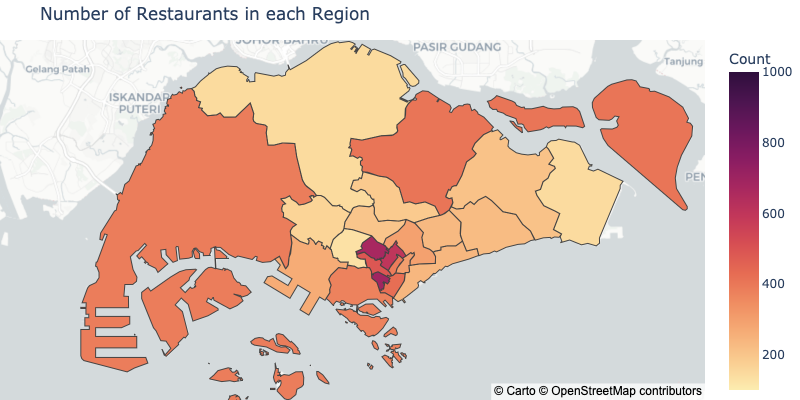

In [31]:
fig = px.choropleth_mapbox(
    gdf_new_region,
    geojson = gdf_new_region.geometry,
    locations = gdf_new_region.index,
    color='num_of_restaurants',
    color_continuous_scale='matter',
    range_color=(100,1000),
    hover_data=['new_region_feature'],
    width=800,
    height=400,
    center= {
        'lat': 1.33,
        'lon': 103.82
    },
    labels={
        'num_of_restaurants': 'Count'
    },    
    zoom=9.8 # 11.2 for CBD
)

fig.update_layout(
    title="Number of Restaurants in each Region",
    margin={'r': 0, 'l': 0, 'b': 0, 't': 40},
    mapbox_accesstoken=mapbox_token,
    mapbox= {'style': 'carto-positron'}
)
fig.show("png")